<img src="dbpedia_getting_started.jpg">

# Getting started with the DBpedia SPARQL endpoint

In this episode I begin to explore the DBpedia public SPARQL endpoint.  I'll go through the following stages

* setting up tools
* counting triples
* counting predicates
* examination of the predicate **pr:skipperlastname**
* countings classes
* examination of the class **on:CareerStation**

My method is a deliberate combination of systematic analysis (looking at counts, methods that can applied to arbitrary predicates or classes) and opportunism
(looking at topics that catch my eye.)  DBpedia is too heterogenous to characterize in one article,  but I'll begin to uncover the dark art of writing SPARQL queries against generic databases.

## Setting up tools

A first step is to import a number of symbols that we'll use to do SPARQL queries and visualize the result

In [1]:
%load_ext autotime
import sys
sys.path.append("../..")
from gastrodon import RemoteEndpoint,QName,ttl,URIRef,model
import pandas as pd
pd.options.display.width=120
pd.options.display.max_colwidth=100

First I'll define a few prefixes for namespaces that I want to use.

In [2]:
prefixes=model("""
    @prefix : <http://dbpedia.org/resource/> .
    @prefix on: <http://dbpedia.org/ontology/> .
    @prefix pr: <http://dbpedia.org/property/> .
""")

time: 8.99 ms


Next I set up a SPARQL endpoint and register the above prefixes so I can use them;  it is also important that I set the default graph and base_uri so we'll get good looking short results.

In [3]:
endpoint=RemoteEndpoint(
    "http://dbpedia.org/sparql/"
    ,default_graph="http://dbpedia.org"
    ,prefixes=prefixes
    ,base_uri="http://dbpedia.org/resource/"
)

time: 3 ms


## Counting Triples

First I count how many triples there are in the main graph

In [4]:
count=endpoint.select("""
    SELECT (COUNT(*) AS ?count) { ?s ?p ?o .}
""").at[0,"count"]
count

433024494

time: 15.9 s


## Counting Predicates

For the next query I make a list of common predicates;  note that there are a whole lot of them!  The public SPARQL endpoint has a limit of 10,000 returned rows and we are finding many more than that.

Each predicate is a relationship between a topic and either another topic or a literal value.  For instance,  the **rdf:type** predicate links a topic to another topic representing a class that the first topic is an instance,  for instance:

```
<Alan_Alda> rdf:type on:Person .
```

**rdfs:label**,  on the other hand,  links topics to literal values,  such as

```
<Alan_Alda> rdfs:label 
                "Alan Alda"@en,
                "アラン・アルダ"@ja . 
```

Strings in RDF (like the one above) are unusual compared to other computer languages because they can contain language tags,  a particularly helpful feature for multilingual databases such as DBpedia.

In [5]:
predicates=endpoint.select("""
    SELECT ?p (COUNT(*) AS ?count) { ?s ?p ?o .} GROUP BY ?p ORDER BY DESC(?count)
""")
predicates

,p,count
0,rdf:type,112493919
1,http://www.w3.org/2002/07/owl#sameAs,33623696
2,http://purl.org/dc/terms/subject,23990506
3,rdfs:label,22430852
4,http://www.w3.org/ns/prov#wasDerivedFrom,15801285
5,on:wikiPageRevisionID,15797811
6,on:wikiPageID,15797811
7,http://purl.org/dc/elements/1.1/language,12845235
8,http://xmlns.com/foaf/0.1/primaryTopic,12845235
9,http://xmlns.com/foaf/0.1/isPrimaryTopicOf,12845234


time: 1min 4s


Some notes.  

First of all,  properties that are original to DBpedia. are in two namespaces;  the **on** namespace contains DBpedia Ontology properties which are better organized (mapped manually) than the **pr** namespace that contains properties that are mapped automatically.  The `select` function returns short names for predicates in these namespaces because I specified them in the prefix list above.

DBpedia also uses predicates that are defined in other namespaces,  such as **foaf** and **dc**.  Frequently these duplicate properties that are defined in DBpedia,  but facilitate interoperability with tools and data that use standard vocabularies.  `select` would show you short names for these to if I added them to the prefix list,  but I didn't,  so it doesn't.

If you look closely,  you might notice we got exactly 10,000 results from this last query.  This is not because DBpedia uses only 10,000 distinct predicates,  but because the DBpedia SPARQL endpoint has a 10,000 row result limit.  This can be annoying sometimes,  but it protects the endpoint from people who write crazy queries.  There is a bag of tricks for dealing with this,  but in the purposes of this article,  10,000 predicates is enough to get started.

This begs the question:

"How many distinct predicates are used in DBpedia?"

which is easy to answer with a SPARQL query:

In [6]:
endpoint.select("""
    SELECT (COUNT(*) AS ?count) { SELECT DISTINCT ?p { ?s ?p ?o .} }
""")

,count
0,60648


time: 43.3 s


When you have a number of "things" ordered by how prevalent there are,  a cumulative distribution function is a great nonparametric method of characterizing the statistics

In [7]:
predicates["dist"]=predicates["count"].cumsum()/count

time: 4 ms


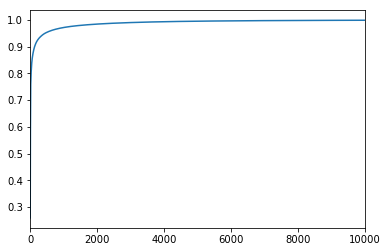

time: 1.26 s


In [8]:
%matplotlib inline
predicates["dist"].plot()

This distribution certainly looks like it has a "knee" somewhere in the teens,  probably involving a transition from predicates that could apply to any topic such as **rdfs:comment** as opposed to predicates specific to certain subject areas,  such as **on:team**.

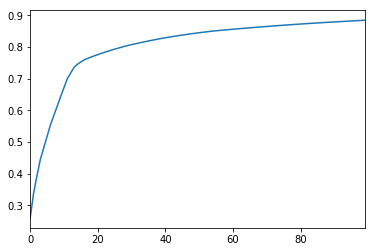

time: 256 ms


In [9]:
predicates["dist"].head(100).plot()

Here are the top 20 predicates,  representing more than 80% of the predicates used in the main graph

In [10]:
predicates.head(30)

,p,count,dist
0,rdf:type,112493919,0.259787
1,http://www.w3.org/2002/07/owl#sameAs,33623696,0.337435
2,http://purl.org/dc/terms/subject,23990506,0.392837
3,rdfs:label,22430852,0.444638
4,http://www.w3.org/ns/prov#wasDerivedFrom,15801285,0.481128
5,on:wikiPageRevisionID,15797811,0.517611
6,on:wikiPageID,15797811,0.554093
7,http://purl.org/dc/elements/1.1/language,12845235,0.583757
8,http://xmlns.com/foaf/0.1/primaryTopic,12845235,0.613421
9,http://xmlns.com/foaf/0.1/isPrimaryTopicOf,12845234,0.643085


time: 36 ms


Looking at the tail,  I find some very random sorts of properties.

In [11]:
predicates.tail()

,p,count,dist
9995,pr:buschCarTeam,135,0.998423
9996,pr:majorsites,135,0.998423
9997,http://dbpedia.org/property/1v4b,135,0.998423
9998,pr:seats1Last,134,0.998424
9999,pr:allamericans,134,0.998424


time: 15 ms


Here are predicates that are at the 90%,  95%, 98%, and 99% cumulative distributions,  just to get a sense of what happens as things get more rare.

In [12]:
predicates[predicates["dist"]>0.9].head(1)

,p,count,dist
132,pr:t,169841,0.900148


time: 12 ms


In [13]:
predicates[predicates["dist"]>0.95].head(1)

,p,count,dist
446,pr:subdivisionName,29914,0.950063


time: 13.5 ms


In [14]:
predicates[predicates["dist"]>0.98].head(1)

,p,count,dist
1563,pr:mainCharTeam,4719,0.980006


time: 15.5 ms


In [15]:
predicates[predicates["dist"]>0.99].head(1)

,p,count,dist
3060,pr:generalManager,1723,0.990001


time: 16 ms


**pr:skipperlastname** (property ranked number 9993) caught my eye,  so I take a look at it.

In [16]:
endpoint.select("""
    SELECT ?s ?o  { ?s pr:skipperlastname ?o  }
""")

,s,o
0,1989–90_Whitbread_Round_the_World_Race,English
1,1993–94_Whitbread_Round_the_World_Race,Field
2,1973–74_Whitbread_Round_the_World_Race,Goodwin
3,1977–78_Whitbread_Round_the_World_Race,James
4,1989–90_Whitbread_Round_the_World_Race,Smith
5,1993–94_Whitbread_Round_the_World_Race,Smith
6,1981–82_Whitbread_Round_the_World_Race,Taylor
7,1985–86_Whitbread_Round_the_World_Race,Taylor
8,Oryx_Quest,Thompson
9,1973–74_Whitbread_Round_the_World_Race,Ainslie


time: 605 ms


Looks like it has to do with sailing.  It's not an area that I know much about,  so I'll transclude the page describing one of the topics from Wikipedia so we can understand it.

In [17]:
from bs4 import BeautifulSoup
from IPython.display import display, HTML
from uritools import urijoin

def transclude(file):
    with open(file,"rt",encoding="utf8") as fp:
        soop = BeautifulSoup(fp,"html5lib")
    for a in soop.find_all("a"):
        a["href"]=urijoin("http://en.wikipedia.org/",a["href"])   
    return HTML(str(soop.body))

time: 278 ms


In [18]:
 transclude("The_Race.html")

Pos,Boat,Crew,Country,Time
1,Club Med,"Dalton, Grant Grant Dalton",New Zealand,62d 6h 56m 33s
2,Innovation Explorer,"Peyron, Loick Loick Peyron & Skip Novak",France,64d 22h 32m 38s
3,Team Adventure,"Lewis, Cam Cam Lewis",United States,82d 20h 21m 02s
4,Warta Polpharma,"Paszke, Roman Roman Paszke",Poland,99d 12h 31m
5,Team Legato,"Bullimore, Tony Tony Bullimore",Great Britain,104d 20h 52m
-,PlayStation,"Fossett, Steve Steve Fossett",United States,DNF[a]
-,Team Philips,"Goss, Pete Pete Goss",Great Britain,DNS


time: 46 ms


That wikipedia page is pretty informative,  let's see what facts are in DBpedia concerning "The Race".

Note that by setting the **BASE**,  I can make it so DBpedia resources (which largely correspond to Wikipedia pages) can be easily written using angle brackets.  It would be tempting to create a namespace for them,  but it turns out that SPARQL and Turtle let you write a wider range of characters insides brackets,  as opposed to in a namespace.  Particularly,  the parenthesis in **`<The_Race_(yachting_race)>`** are legal,  but **`dbpedia:The_Race_(yachting_race)`** is not allowed!

In [19]:
pd.options.display.max_rows=99
endpoint.select("""
    BASE <http://dbpedia.org/resource/>
    SELECT ?p ?o  {<The_Race_(yachting_race)> ?p ?o  }
""")

,p,o
0,rdf:type,http://dbpedia.org/class/yago/WikicatSailingRaces
1,rdf:type,http://dbpedia.org/class/yago/WikicatSportsCompetitionsInSpain
2,rdf:type,http://dbpedia.org/class/yago/Abstraction100002137
3,rdf:type,http://dbpedia.org/class/yago/Contest107456188
4,rdf:type,http://dbpedia.org/class/yago/Event100029378
5,rdf:type,http://dbpedia.org/class/yago/PsychologicalFeature100023100
6,rdf:type,http://dbpedia.org/class/yago/Race107472657
7,rdf:type,http://dbpedia.org/class/yago/SocialEvent107288639
8,rdf:type,http://dbpedia.org/class/yago/YagoPermanentlyLocatedEntity
9,rdfs:label,The Race (yachting race)


time: 553 ms


What's the story here?  Cells from the table have been converted into facts,  but the order of the facts has been scrambled.  We know that one of the boats finished in "5381793.0" seconds,  and we know there was a boat named "Warta_Polpharma" and so forth,  but we don't know which boats finished,  which boats boats finished in what time,  which boat had what skipper,  etc.

This is not a limitation of RDF,  but it is a common limitation of RDF-based systems in the "Linked Data" era,  and it's historically been a problem in RDF.

The basic problem is that if we want to write a statement like the one on the first row of the HTML table,  we end up having to write something like

```
<Some_Node>
  pr:pos 1 ;
  pr:boat <Club_Med> ;
  pr:skipper <Grant_Dalton> ;
  pr:nation "NZL" ;
  pr:time 5381793.0 .
  
<The_Race_(yaching_race)> pr:entry <Some_Node> .
```

the only hard part is determing a name for `<Some_Node>`.  In the case of DBpedia,  names are derived from URIs in Wikipedia,  a formula that doesn't apply when we're talking about a concept that doesn't have a URI in Wikipedia.  We can duck the problem of assigning a name by using a blank node (which states a node exists without giving a specific name) but that causes problems of its own which come from the difficulty of having something nameless in a distributed system.  (What if I want to talk about a nameless entity that exists in DBpedia?)

For specific problems,  it's possible,  and often straightforward,  to find ways to name nodes like `<Some_Node>`.  However,  it is hard to find a solution that pleases everybody,  particularly when we are talking about a system which is decentralized,  in which people would like names to be stable over time,  etc.

With conflicting demands,  it's no wonder that this area has not been standardized by the W3C,  but it's great to see that DBpedia is making some progress in this area,  which I'll show in the next section.

# Classes

Note I started this analysis by looking first at the most commonly used predicates.  If I was looking a SQL database,  this would be like looking at a list of columns first,  and if I was looking at an Object-Oriented program,  it would be like looking at a list of methods and fields.

It would be much more common to look at tables first in SQL or classes first in Java,  but RDF is different from SQL and Java,  and it often makes sense to look at properties first.

For one thing,  it is possible to write properties without defining any classes or categories,  that is,  the RDF statement

```
<SomeTopic> :hasNumber 1023 .
```

is self-sufficient and meaningful without knowledge that `<SomeTopic>` is a particular kind of topic.  Thus,  properties are more fundamental.

More practically,  people get into more trouble with classes than they do with properties.  Part of it is that people tend to argue more about classes (ex. can a [video game be art?](http://www.rogerebert.com/rogers-journal/video-games-can-never-be-art))
than they do about properties (ex. "Hideo Kojima was thge director of Metal Gear Solid") In the case of DBpedia,  one problem is the sheer number of categories:

In [20]:
types=endpoint.select("""
    SELECT ?type (COUNT(*) AS ?count) { ?s a ?type .} GROUP BY ?type ORDER BY DESC(?count)
""")
types

,type,count
0,http://xmlns.com/foaf/0.1/Document,12856178
1,http://www.w3.org/2002/07/owl#Thing,5044222
2,on:Image,2897004
3,http://dbpedia.org/class/yago/PhysicalEntity100001930,2822488
4,http://dbpedia.org/class/yago/Object100002684,2720458
5,http://dbpedia.org/class/yago/YagoLegalActorGeo,2190190
6,http://dbpedia.org/class/yago/Whole100003553,2061271
7,on:Person,1757099
8,http://dbpedia.org/class/yago/YagoPermanentlyLocatedEntity,1654844
9,http://dbpedia.org/class/yago/YagoLegalActor,1548330


time: 35.9 s


In [21]:
endpoint.select("""
    SELECT (COUNT(*) AS ?count) { SELECT DISTINCT ?type { ?s a ?type .} }
""")

,count
0,483605


time: 11.5 s


On average,  that's nearly eight classes for every property!

DBpedia,  it turns out,  contains many types from YAGO,  which are in turn generated from Wikipedia Categories and other data sources.  Many of these classes such as **yago:WikicatPeopleFromYokohama** and **yago:MexicanMaleFilmActors** are classes that are members of very large families that include "People from Lanzarote",  "Brazillian female professional wrestlers" as such.  Two common patterns are:

1. Restriction types:  One could name "People from Yokohama" as a class,  and ask for instances of that class.  Alternatively,  one could query for people for whom the property "comes from" has the value "Yokohama".  A class whose membership is determined by property values is a "restriction type".
2. Intersection types:  "Mexican Person" is a class,  "Male Person" is a class,  "Film Actor" is a class.  The set of topics which are members of all of those classes is "Mexican Male Film Actors".

As you can say the same things with or without restriction and intersection types,  it is a case-by-case decision as to whether to use them or to compose them from other elements.  What is clear,  in this type,  is that there are so many realized restriction and intersection types from YAGO that it gets in the way of seeing what kind of things are talked about in DBpedia.

An easy "set of blinders" to use here is to look only at types that are in the DBpedia Ontology namespace.  Rather than write a new SPARQL query,  I use the filtering operator in Pandas to pick out common types from the DBpedia Ontology.

In [22]:
types[types["type"].str.startswith('on:')]

,type,count
2,on:Image,2897004
7,on:Person,1757099
10,on:Agent,1529881
23,on:TimePeriod,1127706
27,on:CareerStation,977023
28,on:Place,839987
29,on:Location,839987
35,on:PopulatedPlace,513642
39,on:Work,496070
40,on:Settlement,478906


time: 38 ms


**on:Image** catches my eye,  so I look at a few examples and pick one out.

In [23]:
endpoint.select("""
    SELECT ?that { 
        ?that a on:Image
    } LIMIT 10
""")

,that
0,http://en.wikipedia.org/wiki/Special:FilePath/Alfred_Schütz.jpg
1,http://en.wikipedia.org/wiki/Special:FilePath/Aromas.JPG
2,http://en.wikipedia.org/wiki/Special:FilePath/Baldwin_Park_CA_logo.jpg
3,"http://en.wikipedia.org/wiki/Special:FilePath/Bayfield,CO.jpg"
4,http://en.wikipedia.org/wiki/Special:FilePath/Bennettcoskyline.JPG
5,http://en.wikipedia.org/wiki/Special:FilePath/Bitterspring.jpg
6,http://en.wikipedia.org/wiki/Special:FilePath/Boulder_Creek.jpg
7,http://en.wikipedia.org/wiki/Special:FilePath/BrandonFL.gif
8,http://en.wikipedia.org/wiki/Special:FilePath/Buttonwillow.jpg
9,http://en.wikipedia.org/wiki/Special:FilePath/CarberryBookplate.jpg


time: 308 ms


In [24]:
HTML('<img src="{0}">'.format(_.at[0,'that']))

time: 7 ms


These "topics" are what I would call "non-topic topics" in the sense that they are the subject of a statement,  but not an actual "thing in the world" described by the knowledge base.  (Wikipedia documents the outside world primarily,  and only secondarily has a metadata catalog for items that are in it.)

The following query finds "plain ordinary topics"

In [25]:
endpoint.select("""
    SELECT ?that { 
        ?that a on:Person
    } LIMIT 10
""")

,that
0,Andreas_Ekberg
1,Danilo_Tognon
2,Lorine_Livington_Pruette
3,Megan_Lawrence
4,Nikolaos_Ventouras
5,Peter_Ceffons
6,Sani_ol_molk
7,Siniša_Žugić
8,"William_Bagot,_2nd_Baron_Bagot"
9,Witold_Gerutto


time: 320 ms


"Andres_Ekberg" is a shorthand for [`<http://dbpedia.org/resource/Andreas_Ekberg>`](https://en.wikipedia.org/wiki/Andreas_Ekberg) which is parallel to the Wikipedia page at
[`<http://en.wikipedia.org/wiki/Andres_Ekberg>`](https://en.wikipedia.org/wiki/Andreas_Ekberg).  The select() method shows just "Andreas_Ekberg" because I registered `<http://dbpedia.org/resource/>` as the base URI of this endpoint when I created the `endpoint` object way back at the beginning of this notebook.

What most people would think of as "topics" in DBpedia live in the `<http://dbpedia.org/resource/>` namespace.

Another common kind of topic in DBpedia is the **on:Agent**:

In [26]:
endpoint.select("""
    SELECT ?that { 
        ?that a on:Agent
    } LIMIT 10
""")

,that
0,3Com
1,7-Eleven
2,A._C._Bhaktivedanta_Swami_Prabhupada
3,Aardman_Animations
4,Aaron_Burr
5,Abbie_Hoffman
6,About.com
7,Abraham_Robinson
8,Abraham_de_Moivre
9,Academy_of_Motion_Picture_Arts_and_Sciences


time: 322 ms


The "Agent" concept is connected with the shared attributes of individuals and organizations;  I like to think that an "Agent" is something that can be the originator or recipient of a communication.  If I remove people using the **MINUS** operator,  only organizations remain.

In [27]:
endpoint.select("""
    SELECT ?that { 
        ?that a on:Agent
        MINUS {?that a on:Person}
    } LIMIT 10
""")

,that
0,3Com
1,7-Eleven
2,Aardman_Animations
3,About.com
4,Academy_of_Motion_Picture_Arts_and_Sciences
5,Acorn_Computers
6,Activision
7,"Ad_Lib,_Inc."
8,Adnams_Brewery
9,Aermacchi


time: 645 ms


Unlike the classes I've shown so far,  a **on:TimePeriod** can be either a topic or non-topic.  Asking for just 10 time periods,  I find that some of them correspond to calendar years:

In [28]:
endpoint.select("""
    SELECT ?that { 
        ?that a on:TimePeriod
    } LIMIT 10
""")

,that
0,1
1,10
2,100
3,1000
4,1001
5,1002
6,1003
7,1004
8,1005
9,1006


time: 310 ms


In [29]:
 transclude("1004.html")

time: 48 ms


If,  however,  I make a query that eliminates topics that start with a number,  the query returns a large number of non-topics.  Even though these resources are in the `<http://dbpedia.org/resource/>` namespace,  they don't have corresponding Wikipedia pages.

In [30]:
endpoint.select("""
    SELECT ?that { 
        ?that a on:TimePeriod .
        FILTER(STRSTARTS(STR(?that),"http://dbpedia.org/resource/A"))
    } LIMIT 10
""")

,that
0,A._M._A._Azeez__1
1,A._R._Colquhoun__1
2,Abbie_Wolanow__1
3,Abbie_Wolanow__2
4,Abbie_Wolanow__3
5,Abbie_Wolanow__4
6,Abbie_Wolanow__5
7,Abdul_Wahab_Khan__1
8,Adam_Wolanin__1
9,Adam_Wolanin__2


time: 840 ms


Let's take a closer look.  It seems that this record describes a time that a soccer player spent playing for a team (although unfortunately it doesn't say when this time began or ended):

In [31]:
endpoint.select("""
    BASE <http://dbpedia.org/resource/>
    SELECT ?p ?o { 
        <Abbie_Wolanow__1> ?p ?o .
    }
""")

,p,o
0,rdf:type,http://www.w3.org/2002/07/owl#Thing
1,rdf:type,on:CareerStation
2,rdf:type,on:TimePeriod
3,on:team,Hapoel_Tel_Aviv_F.C.


time: 307 ms


This record is more complete,  and shows how the career record can be linked to a time,  as well as information about how the player performed:

In [32]:
endpoint.select("""
    BASE <http://dbpedia.org/resource/>
    SELECT ?p ?o { 
        <Abbie_Wolanow__5> ?p ?o .
    }
""")

,p,o
0,rdf:type,http://www.w3.org/2002/07/owl#Thing
1,rdf:type,on:CareerStation
2,rdf:type,on:TimePeriod
3,on:numberOfGoals,0
4,on:numberOfMatches,1
5,on:team,United_States_men's_national_soccer_team
6,on:years,1961-01-01


time: 310 ms


Going to the right of the career station (finding objects for which it is the subject) we see the team,  but we don't see the player.  Going to the left,  however (finding objects for which it is the subject) we see the player.

In [33]:
endpoint.select("""
    BASE <http://dbpedia.org/resource/>
    SELECT ?s ?p  { 
        ?s ?p <Abbie_Wolanow__5> .
    }
""")

,s,p
0,Abbie_Wolanow,on:careerStation


time: 307 ms


Thus this fragment of the RDF graph looks like:
    
<img src="Wolanow5.png">

and this a general pattern for how one might deal with situations where we want to say something more complex than "Abbie Wolanow played for the U.S. Men's National Soccer Team".

In terms of the source data,  Career stations are much like the race entries in the yachting example in that a single page on Wikipedia contains a number of "sub-topics" that need to be referred to in order to keep together facts such as "**this boat** was the third finisher" and "Cam Lewis was the skipper of **this boat**"

The difference is that DBpedia identifies individual career stations while it does not indentify individual race entries.

Here is a survey of the different predicate types that are used to
describe career stations.  I was probably a bit unlucky to pick a player who didn't have **on:years** specified very often:

In [34]:
endpoint.select("""
    SELECT ?p (COUNT(*) AS ?count) { 
        ?that a on:CareerStation .
        ?that ?p ?o .
    } GROUP BY ?p ORDER BY DESC(?count)
""")

,p,count
0,rdf:type,2931158
1,on:team,941316
2,on:years,927710
3,on:numberOfGoals,647584
4,on:numberOfMatches,645122
5,on:title,12
6,on:description,2
7,on:filename,2
8,on:country,1
9,on:deathDate,1


time: 3.14 s


What sort of people have career stations?  I count the career stations and get the following results:

In [35]:
pd.options.display.max_rows=20
has_cs_types=endpoint.select("""
    SELECT ?type (COUNT(*) AS ?count) { 
        ?station a on:CareerStation .
        ?who on:careerStation ?station .
        ?who a ?type .
    } GROUP BY ?type ORDER BY DESC(?count)
""")
has_cs_types[has_cs_types["type"].str.startswith("on:")]

,type,count
1,on:Person,977021
5,on:Agent,977021
24,on:Athlete,779570
25,on:SoccerPlayer,779570
27,on:SoccerManager,197451
28,on:SportsManager,197451


time: 24.9 s


Career stations seem heavily weighted towards people who play soccer!  The numbers above are hard to compare to other characteristics,  however,  because they are counting the career stations instead of the people.  For instance,  Abbie Wolanow is counted five times because he has five career stations.

With a slightly different query,  I can count the actual number of people of various types who have career stations.

In [36]:
has_cs_types=endpoint.select("""
    SELECT ?type (COUNT(*) AS ?count) {
        { SELECT DISTINCT ?who {
            ?station a on:CareerStation .
            ?who on:careerStation ?station .
        } }
        ?who a ?type .
    } GROUP BY ?type ORDER BY DESC(?count)
""")
has_cs_types[has_cs_types["type"].str.startswith("on:")]

,type,count
1,on:Person,135887
5,on:Agent,135887
11,on:Athlete,117270
12,on:SoccerPlayer,117270
27,on:SoccerManager,18617
28,on:SportsManager,18617
8781,on:FictionalCharacter,11


time: 21.5 s


Note that the counts here do not need to add up to anything in particular,  because it is possible for someone to be in more than one category at a time.  For instance,  we see the same count for `on:Person` and `on:Agent` as well as `on:Athlete` and `on:SoccerPlayer` because each soccer player is an athlete.  I got suspicious,  however,  and found that if I added the number of soccer players to the number of soccer managers...

In [37]:
18617+117270

135887

time: 4.5 ms


... and found they were equal!  That suggests that all of the people with career stations are involved with soccer,  and that **on:SoccerPlayer** and **on:SoccerManager** are mutually exclusive.

I test that mutually exclusive bit by counting the number of topics which are both soccer players and soccer managers:

In [38]:
endpoint.select("""
    SELECT (COUNT(*) AS ?count) {
        ?x a on:SoccerPlayer .
        ?x a on:SoccerManager .
    }
""")

,count
0,0


time: 313 ms


Those two really are mutually exclusive.

This seems strange to me.  I don't know much about soccer (I am from the U.S. after all!) but frequently coaches and team managers are former players in other sports,  shoudn't they be in soccer?

I investigate just a bit more,  first getting a sample of managers...

In [39]:
endpoint.select("""
    SELECT ?x {
        ?x a on:SoccerManager .
    } LIMIT 10
""") 

,x
0,Alan_Shearer
1,Alex_Ferguson
2,Dennis_Bergkamp
3,Enzo_Scifo
4,Marco_van_Basten
5,Osvaldo_Ardiles
6,Ruud_Gullit
7,Walter_Winterbottom
8,Alejandro_Morera_Soto
9,"Aleksandr_Smirnov_(footballer,_born_1968)"


time: 319 ms


... and then looking at the text description of one in particular:

In [40]:
endpoint.select("""
    SELECT ?comment  { 
       <http://dbpedia.org/resource/Alex_Ferguson> rdfs:comment ?comment .
       FILTER(LANG(?comment)='en')
    }
""").at[0,"comment"]

'Sir Alexander Chapman "Alex" Ferguson, CBE (born 31 December 1941) is a former Scottish football manager and player who managed Manchester United from 1986 to 2013. He is regarded by many players, managers and analysts to be one of the greatest and most successful managers of all time.'

time: 319 ms


As I suspected,  Alex Ferguson was a player who became a manager.  These things are not mutually exclusive in the real world,  although they are mutually exclusive in DBpedia.

It's a typical example of what you find when you look at "how things are" as opposed to "how things are supposed to be".  

If it were up to me you'd be a soccer player if you'd ever played soccer and you'd be a manager if you'd ever managed a soccer team.  On the other hand,  I don't have my own database of thousands of soccer players (and managers!) so having to accept data in the format it is provided in is part of the price of "free" data.

# Conclusion

In this article I began an investigation of data in DBpedia that particularly focused on two kinds of topics:  race entries and the careers of soccer players.  In the first case,  information about different entries in the race are scrambled,  because no subject is introduced for each entry.  In the second case,  DBpedia provides identifiers for "Career Stations" upon which it can state facts such as what team a person played on,  for what time period,  and so forth.

I hope very much that the "Career Station" is the future of DBpedia because there are many other things that can be modeled very similarly such as:

* a person's educational career
* the work career of a person who works for multiple employers over time
* times in which a person has been a member of a band
* locations of a concert tour
* results of a series of sports events

Introduced in DBpedia 3.9,  "Career Station" is relatively new.  Other generic databases such as Freebase and Wikidata have used mechanisms such as [compound value types](http://basekb.com/docs/manual/compound-value-types.php) and [qualifiers](https://www.wikidata.org/wiki/Help:Qualifiers) to similar effect.  Let's hope that the enthusiasm soccer fans have brought to DBpedia will carry over to other sports and endeavors!

<img src="goooal.jpg">




<table width="600" align="center"> 
    <tbody>
     <tr>
      <td style="background: navy; align:center">
       <div style="color: white; text-align:center">
         This article is part of a series.<br>
         Subscribe to my mailing list to be notified when new installments come out.
        <br>&nbsp;
        <br> 
        <form action="https://legalentityidentifier.info/lei/submitForm" method="post"> 
         <input name="email" value=""> 
         <input type="hidden" name="what" value="rs-book"> 
         <input type="hidden" name="v" value="24c0e1c0-ab8a-4068-806d-71e6db4ca6fc"> 
         <input type="submit" name="action" value="Subscribe!" style="color: black"> 
        </form> 
       </div></td>
     </tr> 
    </tbody>
   </table><script>
  (function(i,s,o,g,r,a,m){i['GoogleAnalyticsObject']=r;i[r]=i[r]||function(){
  (i[r].q=i[r].q||[]).push(arguments)},i[r].l=1*new Date();a=s.createElement(o),
  m=s.getElementsByTagName(o)[0];a.async=1;a.src=g;m.parentNode.insertBefore(a,m)
  })(window,document,'script','https://www.google-analytics.com/analytics.js','ga');

  ga('create', 'UA-3262918-17', 'auto');
  ga('send', 'pageview');
</script>